In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch
from unet import UNet
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from train import train_one_epoch, validate_batch


In [2]:
from datasets.coco import create_coco_dataloaders

# Load the data
base_path = 'data'  # base path of where the coco dataset is stored
train_loader, val_loader, test_loader = create_coco_dataloaders(
    base_path=base_path,
    batch_size=8,
    num_workers=4
)

loading annotations into memory...


Done (t=13.09s)
creating index...
index created!
loading annotations into memory...
Done (t=0.41s)
creating index...
index created!


In [11]:
images, masks = next(iter(train_loader))
print(f"Image size: {images.size()}")
print(f"Mask size: {masks.size()}")

Image size: torch.Size([8, 3, 256, 256])
Mask size: torch.Size([8, 256, 256])


In [4]:
coco_dataset = train_loader.dataset
categories = coco_dataset.categories
num_classes = coco_dataset.num_classes  # This will be 81 (80 classes + background)
print(f"Number of classes: {num_classes}")

Number of classes: 81


In [5]:
# Create a mapping of category IDs to names
COCO_CLASSES = {0: 'Background'}  # Start with background
for idx, category in enumerate(categories, 1):
    COCO_CLASSES[idx] = category['name']

In [6]:
# Create a color palette for visualization
COLOR_PALETTE = {0: (0, 0, 0)}  # Background: Black
for i in range(1, num_classes):
    # Generate a unique color for each class using HSV color space
    hue = i / num_classes
    rgb = plt.cm.hsv(hue)[:3]  # Convert HSV to RGB
    COLOR_PALETTE[i] = tuple(int(x * 255) for x in rgb)


In [7]:
# Function to plot colormap legend
def plot_colormap_legend():
    num_cols = 10
    num_rows = (num_classes + num_cols - 1) // num_cols
    fig, ax = plt.subplots(figsize=(20, num_rows * 2))

    for idx, (class_id, class_name) in enumerate(COCO_CLASSES.items()):
        row = idx // num_cols
        col = idx % num_cols
        color = [x/255 for x in COLOR_PALETTE[class_id]]
        ax.add_patch(plt.Rectangle((col, -row), 1, 1, facecolor=color))
        ax.text(col + 0.5, -row + 0.5, class_name[:15] + '...' if len(class_name) > 15 else class_name,
                ha='center', va='center', rotation=45, fontsize=10)

    ax.set_xlim(0, num_cols)
    ax.set_ylim(-num_rows, 1)
    ax.axis('off')
    plt.title('COCO Classes Color Map')
    plt.tight_layout()
    plt.show()

In [8]:
# Function to plot images and masks
def plot_images_and_masks(images, masks, n_samples=4):
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 6))
    for i in range(n_samples):
        # Plot image
        img = images[i].permute(1, 2, 0).numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[0, i].imshow(img)
        axes[0, i].axis('off')
        axes[0, i].set_title('Image')

        # Plot mask
        mask = masks[i].numpy()
        colored_mask = np.zeros((*mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            colored_mask[mask == class_id] = [x/255 for x in color]
        axes[1, i].imshow(colored_mask)
        axes[1, i].axis('off')
        axes[1, i].set_title('Mask')

    plt.tight_layout()
    plt.show()

In [9]:
# Plot the first batch and color legend
# plot_colormap_legend()

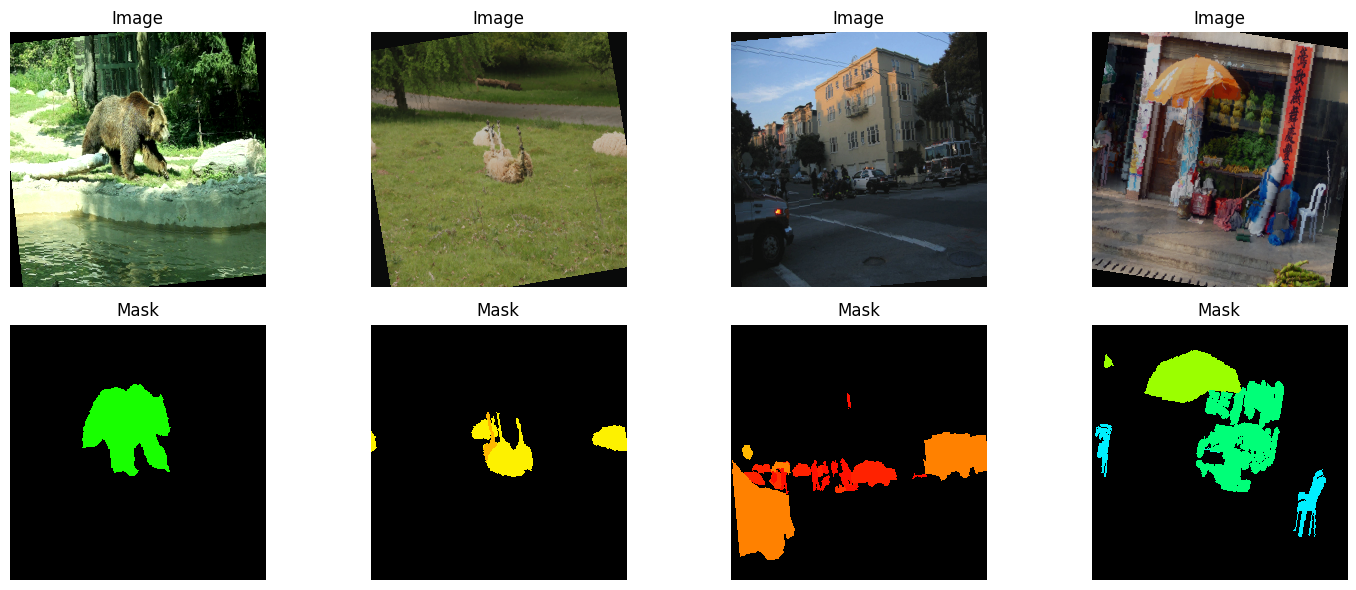

In [16]:
images, masks = next(iter(train_loader))
plot_images_and_masks(images, masks)

In [10]:
# Training setup
from early_stopping import EarlyStopping

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = UNet(n_channels=3, n_classes=num_classes, dropout_rate=0.3, use_batchnorm=True).to(device)

criterion = CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.1,
    patience=5,
    min_lr=1e-6
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    min_delta=0.003,
    patience=10,
    verbose=1,
    mode='min',
    restore_best_weights=True
)
# Training history
history = {
    'train_loss': [],
    'val_loss': [],
    'val_iou': [],
    'learning_rates': []
}


In [11]:
# Training loop
num_epochs = 2
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    # Training phase
    train_loss, train_metrics = train_one_epoch(model, train_loader, criterion, optimizer, device, num_classes)

    # Validation phase
    val_loss, val_metrics = validate_batch(model, val_loader, criterion, device, num_classes)

    # Update learning rate
    current_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_loss)

    # Store history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    for key, value in train_metrics.items():
        history[f'train_{key}'].append(value)
    for key, value in val_metrics.items():
        history[f'val_{key}'].append(value)
    history['learning_rates'].append(current_lr)

    # Print metrics
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Train IoU: {train_metrics['iou']:.4f}")
    print(f"Train Dice: {train_metrics['dice']:.4f}")
    print(f"Val Loss: {val_loss:.4f}")
    print(f"Val Dice: {val_metrics['dice']:.4f}")
    print(f"Val IoU: {val_metrics['iou']:.4f}")
    print(f"Learning Rate: {current_lr:.6f}")


    # Check early stopping
    if early_stopping(epoch, model, val_loss):
        print(f"\nTraining stopped early at epoch {epoch+1}")
        break

# Save the final model and history
torch.save(model.state_dict(), 'coco_ce_final_model.pth')
import pickle
with open('coco_ce_training_history.pkl', 'wb') as f:
    pickle.dump(history, f)


Epoch 1/2


 20%|█▉        | 2919/14786 [1:21:17<2:07:15,  1.55it/s, loss=1.75, train_dice=0.0387, train_iou=0.0315, train_precision=0.0315, train_recall=0.05, train_f1_score=0.0387]    

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.subplot(1, 2, 2)
plt.plot(history['val_iou'], label='Val IoU')
plt.xlabel('Epoch')
plt.ylabel('IoU')
plt.legend()
plt.title('Validation IoU')

plt.tight_layout()
plt.show()

In [ ]:
# Load the best model and run predictions
import torch
from unet import UNet
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(images, masks, predictions, n_samples=4):
    """
    Plot images, ground truth masks, and predicted masks side by side
    Args:
        images: Tensor of shape (B, C, H, W)
        masks: Tensor of shape (B, H, W)
        predictions: Tensor of shape (B, C, H, W)
        n_samples: Number of samples to display
    """
    # Get predictions
    pred_masks = torch.argmax(predictions, dim=1)

    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5*n_samples))

    for i in range(n_samples):
        # Plot original image
        img = images[i].permute(1, 2, 0).cpu().numpy()
        # Denormalize image
        img = img * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
        img = np.clip(img, 0, 1)
        axes[i, 0].imshow(img)
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Image')

        # Plot ground truth mask
        mask = masks[i].cpu().numpy()
        colored_mask = np.zeros((*mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            colored_mask[mask == class_id] = [x/255 for x in color]
        axes[i, 1].imshow(colored_mask)
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Ground Truth')

        # Plot predicted mask
        pred_mask = pred_masks[i].cpu().numpy()
        colored_pred = np.zeros((*pred_mask.shape, 3))
        for class_id, color in COLOR_PALETTE.items():
            colored_pred[pred_mask == class_id] = [x/255 for x in color]
        axes[i, 2].imshow(colored_pred)
        axes[i, 2].axis('off')
        axes[i, 2].set_title('Prediction')

    plt.tight_layout()
    plt.show()

def get_batch_predictions(model, data_loader, num_batches=1):
    """
    Get predictions for a few batches from the data loader
    """
    model.eval()
    all_images = []
    all_masks = []
    all_predictions = []

    with torch.no_grad():
        for i, (images, masks) in enumerate(data_loader):
            if i >= num_batches:
                break

            images = images.to(device)
            predictions = model(images)

            all_images.append(images)
            all_masks.append(masks)
            all_predictions.append(predictions)

    return (torch.cat(all_images, 0),
            torch.cat(all_masks, 0),
            torch.cat(all_predictions, 0))

# Load the best model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loaded_model = UNet(n_channels=3, n_classes=num_classes).to(device)
loaded_model.load_state_dict(torch.load('coco_ce_final_model.pth'))
loaded_model.eval()

# Get predictions for a few test batches
test_images, test_masks, test_predictions = get_batch_predictions(loaded_model, test_loader, num_batches=1)

# Plot the results
plot_predictions(test_images, test_masks, test_predictions, n_samples=4)

# Calculate and print metrics for the test set
test_loss, test_metrics = validate_batch(loaded_model, test_loader, criterion, device, num_classes)
print("\nTest Set Metrics:")
print(f"Loss: {test_loss:.4f}")
print(f"IoU: {test_metrics['iou']:.4f}")
print(f"Dice Score: {test_metrics['dice']:.4f}")
print(f"Precision: {test_metrics['precision']:.4f}")
print(f"Recall: {test_metrics['recall']:.4f}")
print(f"F1 Score: {test_metrics['f1_score']:.4f}")

# Print per-class IoU scores
print("\nPer-class IoU scores:")
for class_id, class_name in COCO_CLASSES.items():
    iou_key = f'class_{class_id}_iou'
    if iou_key in test_metrics:
        print(f"{class_name}: {test_metrics[iou_key]:.4f}")